In [1]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import cv2
from IPython.display import display, Image

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [2]:
Train_Folder ='C:/Users/kevr0/OneDrive/Desktop/CPS-584/sculpture/Landscape/train1/'
image_files= [f for f in os.listdir(Train_Folder) if f.endswith('.jpg')]


In [3]:
sketch_list = []
image_list = []

def generate_image(image_path):
    og_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    n_image = cv2.resize(og_image, (128, 128))
    n_image[0] = n_image[0]/255.0
    n_image[1] = n_image[1]/255.0
    return n_image

def generate_outline(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    n_image = cv2.resize(image, (256, 256))
    blurred = cv2.GaussianBlur(n_image, (3, 3), 1)
    edges = cv2.Canny(blurred, 30, 60)
    inverted_edges = cv2.bitwise_not(edges)
    resized_image = cv2.resize(inverted_edges, (128, 128))
    gray_image_final = resized_image/255.0
    return gray_image_final

for image_file in image_files:
    image_path = os.path.join(Train_Folder, image_file)
    image_list.append(generate_image(image_path))
    sketch_list.append(generate_outline(image_path))
    
sketch_list[1].shape

(128, 128)

In [4]:
image_list[1].shape

(128, 128, 3)

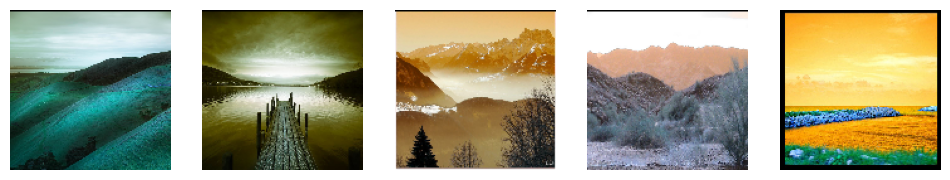

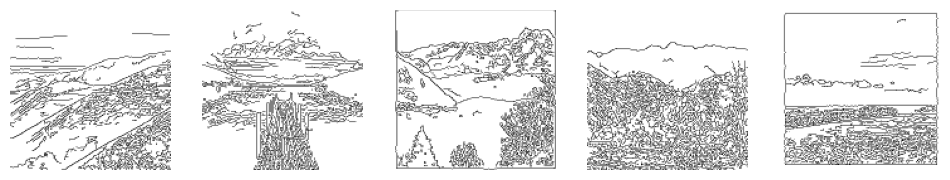

In [5]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_list[i], cmap='gray')
    plt.axis('off')
plt.show()
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sketch_list[i], cmap='gray')
    plt.axis('off')
plt.show()

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class ImageSketchDataset(Dataset):
    def __init__(self, images, sketches, transform=None):
        self.images = images
        self.sketches = sketches
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        sketch = self.sketches[idx]
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            sketch = self.transform(sketch)
        
        return {'image': image, 'sketch': sketch}

# Convert images and sketches to PyTorch tensors
transform = ToTensor()

# Create the dataset
dataset = ImageSketchDataset(image_list, sketch_list, transform=transform)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [7]:
for batch in dataloader:
    images = batch['image']
    sketches = batch['sketch']
    print('Batch of images shape:', images.shape)
    print('Batch of sketches shape:', sketches.shape)
    break

Batch of images shape: torch.Size([2, 3, 128, 128])
Batch of sketches shape: torch.Size([2, 1, 128, 128])


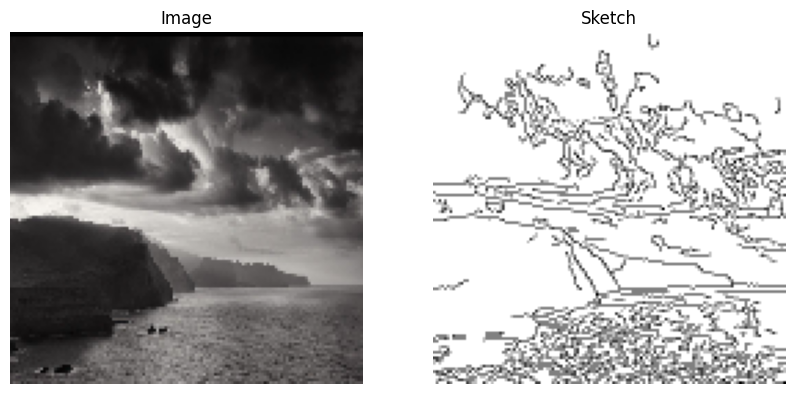

In [8]:
for batch in dataloader:
    images = batch['image']
    sketches = batch['sketch']
    break

# Select the first image and sketch from the batch
image = images[0].numpy().transpose(1, 2, 0)  # Convert from CHW to HWC format
sketch = sketches[0].numpy().squeeze()  # Remove single-channel dimension if necessary

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the image
ax[0].imshow(image)
ax[0].set_title('Image')
ax[0].axis('off')

# Display the sketch
ax[1].imshow(sketch, cmap='gray')
ax[1].set_title('Sketch')
ax[1].axis('off')

plt.show()

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input layer
            nn.ConvTranspose2d(1, 256, kernel_size=4, stride=1, padding=1),  # Output: (128, 128, 256)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (256, 256, 128)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (512, 512, 64)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # Output: (512, 512, 32)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),  # Output: (512, 512, 3)
            nn.Tanh()  # Output values between -1 and 1
        )
    
    def forward(self, x):
        return self.model(x)


In [11]:
# model = Generator().to(device)
# print(model)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input layer
            nn.Conv2d(3, 128, kernel_size=5, stride=1, padding=2),  # padding='same' in TensorFlow
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Conv2d(128, 64, kernel_size=4, stride=1, padding=2),  # padding='same' in TensorFlow
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2),  # padding='same' in TensorFlow
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=2),  # padding='same' in TensorFlow
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Flatten(),
            nn.Linear(266256, 1),  # Adjust this based on the size of the flattened tensor
            nn.Sigmoid()  # Output a single value between 0 and 1
        )
    
    def forward(self, x):
        return self.model(x)
    
# model = Discriminator().to(device)
# print(model)


In [13]:
def train_gan(generator, discriminator, dataloader, num_epochs=500, device='cuda'):
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for batch in dataloader:
            real_images = batch['image'].to(device).float() 
            sketches = batch['sketch'].to(device).float() 
            
            # Training Discriminator
            optimizer_d.zero_grad()
            
            # Real images
            labels = torch.ones(real_images.size(0), 1).to(device)
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, labels)
            
            # Fake images
            fake_images = generator(sketches)
            labels = torch.zeros(real_images.size(0), 1).to(device)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, labels)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()
            
            # Training Generator
            optimizer_g.zero_grad()
            
            labels = torch.ones(real_images.size(0), 1).to(device)
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, labels)
            
            g_loss.backward()
            optimizer_g.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

train_gan(generator, discriminator, dataloader, num_epochs=500, device=device)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x4276624 and 266256x1)